In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
""
from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Experimental Setup

In [177]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"

model_kwargs = {'gas_name':'Xenon', 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)


### Fit to Initial Experimental Values

In [178]:
import warnings
# Suppress warnings from fitting initial conditions
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    def fit_initial_condition(Te_exp, FWHM_exp , **kwargs ):
        def find_exp_params(inputs):
            Te_peak, Te_FWHM = inputs
            Xenon_jt = Experiment(grid, n0, Z, A, Te_peak, Te_FWHM, **kwargs)

            ttm = HydroModel(Xenon_jt, model=kwargs['model'])
            exp = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
            return Te_exp - exp.Te_fit, FWHM_exp - exp.FWHM 
        sol = root(find_exp_params, (Te_exp, 2*FWHM_exp))
        return sol

    initial_conditions = fit_initial_condition(Xe_data['T[kK]'][0]*1e3, Xe_FWHM_data['FWHM[μm]'][0]/1e6,**model_kwargs)
# Show success of initial condition fit     
print(initial_conditions)
Te_initial, gaussian_FWHM = initial_conditions.x
Xenon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

ttm = HydroModel(Xenon, model = model_kwargs["model"])

# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Xe_FWHM_data['FWHM[μm]'][0], Xe_data['T[kK]'][0]))
print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.522e-03  1.466e-16]
       x: [ 1.822e+04  1.052e-04]
    nfev: 19
    fjac: [[-1.000e+00 -7.080e-16]
           [ 7.080e-16 -1.000e+00]]
       r: [-3.000e+05  1.197e+14  4.841e-01]
     qtf: [-1.522e-03 -1.455e-16]

Exp: FWHM = 51.18 [μm], Te = 16.61 [kK]
Sim: FWHM = 51.18 [μm], Te = 16.61 [kK]


/home/zach/plasma/TTM/physics.py:300: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/TTM/physics.py:350: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)


### Plotting Initial Experimental Setup

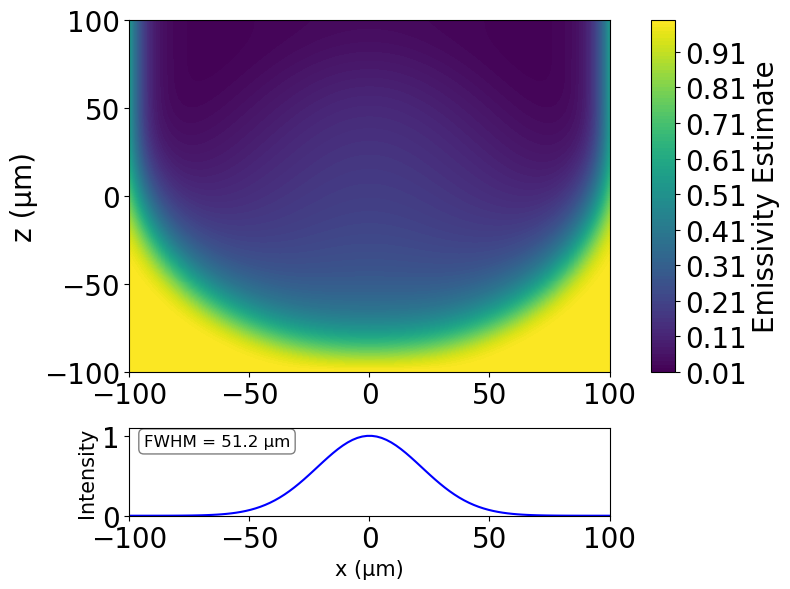

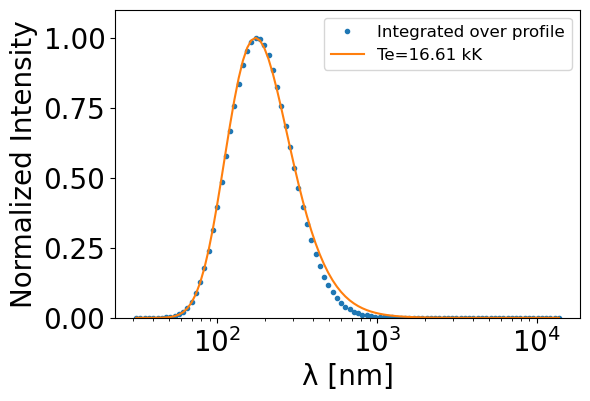

In [179]:
initial_setup.plot_emissivity_and_intensity()
initial_setup.plot_spectral_Intensity()

In [180]:
JT_GMS.Theta(ttm.n_e, ttm.Te)

array([  13.29522048,   13.29328327,   13.28747356,   13.27779716,
         13.2642637 ,   13.24688665,   13.22568332,   13.2006748 ,
         13.17188593,   13.1393453 ,   13.10308516,   13.06314141,
         13.01955356,   12.97236461,   12.92162107,   12.86737285,
         12.80967318,   12.74857858,   12.68414875,   12.61644652,
         12.54553772,   12.47149114,   12.39437843,   12.31427401,
         12.23125496,   12.14540095,   12.05679414,   11.96551907,
         11.87166259,   11.77531376,   11.67656371,   11.57550561,
         11.47223454,   11.36684742,   11.2594429 ,   11.15012127,
         11.0389844 ,   10.92613566,   10.81167983,   10.69572302,
         10.57837265,   10.45973733,   10.33992686,   10.21905217,
         10.09722528,    9.97455926,    9.85116824,    9.72716739,
          9.60267293,    9.47780214,    9.35267342,    9.2274063 ,
          9.10212153,    8.97694119,    8.85198872,    8.72738916,
          8.60326919,    8.47975739,    8.35698444,    8.23508

# Run Hydrodynamic Simulation

In [175]:
%%time
ttm.solve_hydro(tmax=18e-9, dt=1e-10)

KeyboardInterrupt: 

array([  11.76069745,   11.75998876,   11.75537395,   11.74776209,
         11.73495042,   11.72002654,   11.70025176,   11.67670982,
         11.6502876 ,   11.6196709 ,   11.58504129,   11.54710097,
         11.50581656,   11.46091512,   11.41230786,   11.36004955,
         11.30423266,   11.24493724,   11.18223132,   11.11617944,
         11.04685215,   10.97431221,   10.89862196,   10.81986432,
         10.73810226,   10.65341564,   10.5658867 ,   10.47559459,
         10.38264103,   10.28709528,   10.1890781 ,   10.08866516,
          9.98598238,    9.88112169,    9.77421012,    9.66535479,
          9.55468313,    9.44231651,    9.32839189,    9.21303844,
          9.09640796,    8.97863085,    8.859871  ,    8.74027676,
          8.62001096,    8.49924142,    8.37813422,    8.25687632,
          8.13564054,    8.01462285,    7.89401938,    7.77403579,
          7.65487807,    7.53677465,    7.41994998,    7.30464718,
          7.19111825,    7.0796295 ,    6.97046212,    6.86391

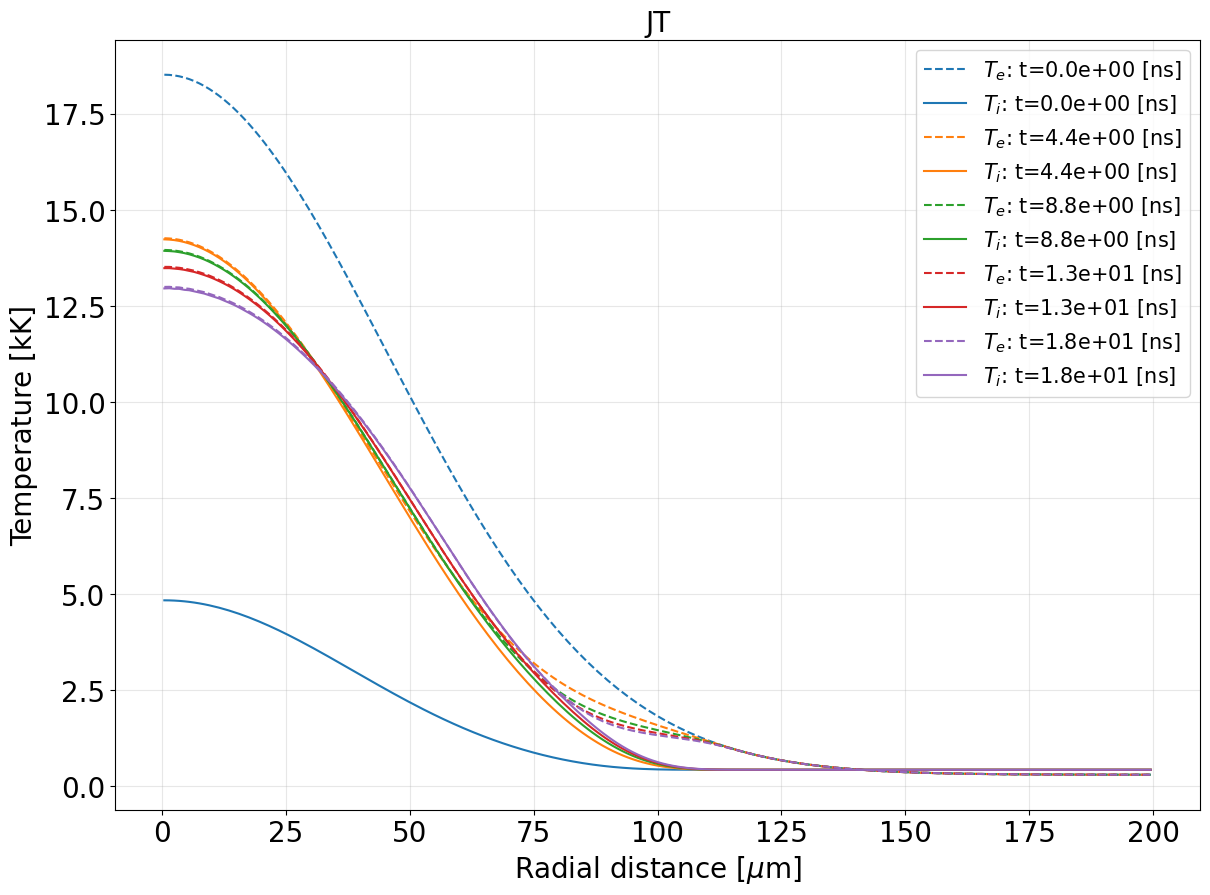

In [7]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=5,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, ttm.v_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title='JT', normalized=False, plot_times=None)#[12,13,14])


### Process Experimental Results at all times 

In [8]:
%%time
FWHM_list = []
FWHM_indices = list(range(len(ttm.t_saved_list)))
FWHM_indices.sort()
FWHM_t_list = [] 
Te_fit_list = []

for i in FWHM_indices:#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 100, Nz=100)
    FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)
    FWHM_t_list.append(ttm.t_saved_list[i])

CPU times: user 23.7 s, sys: 409 ms, total: 24.1 s
Wall time: 24.1 s


# Comparison to Experiment
### Functions to Fit To

In [97]:
def FWHM_fit_form(t, FWHM_0, vf, τ_ei, vei, t01, t02, shift):

    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( (t-t01)/τ_ei )))* (vei*(t-t02)) + shift
# p0 = [22, 1.2, 1/1.30415156,  1.4e6,-9.31586357e+00, 7.7e+05/1.4e6, 25 ]
FWHM_sim_vals = curve_fit(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0 = [22, 1.2, 1/1.30415156,  1.4e6,-9.31586357e+00, 7.7e+05/1.4e6, 25 ])[0]

/tmp/ipykernel_14219/4229082706.py:3: RuntimeWarning: overflow encountered in exp
  return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( (t-t01)/τ_ei )))* (vei*(t-t02)) + shift


In [154]:
def T_fit_form(t, Te_0, Ti_0, τei,dTdt):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - dTdt*t + ΔT0/2*np.exp(-2*t/τei)

curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] ,maxfev=int(1e5))[0]

array([16.64487111,  9.3225703 ,  2.43550564,  0.12757051])

In [156]:
def T_fit_form(t, Te_0, Ti_0, τei, dTdt, t01,t02,τ_switch):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 + ΔT0/2*np.exp(-2*t/τei) - (1- 1/(1+np.exp( (t-t01)/τ_switch )))* (dTdt*(t-t02))

curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] ,maxfev=int(1e5))#[0], 
#           p0=[16.64487111,  9.3225703 ,  2.43550564,  0.12757051,0][0]

(array([ 16.93180735,  10.61707006,   1.600732  ,   0.10577192,
          2.5808619 , -10.46561239,   1.50963202]),
 array([[ 3.11359034e-01,  1.13256950e+00, -2.06136776e-01,
         -3.64143475e-03, -1.19082747e+00, -7.72927279e+00,
          4.11702661e-01],
        [ 1.13256950e+00,  4.21274480e+00, -7.77222772e-01,
         -1.20209971e-02, -4.40787566e+00, -2.82562835e+01,
          1.45325676e+00],
        [-2.06136776e-01, -7.77222772e-01,  1.54264693e-01,
          1.86212259e-03,  8.01229091e-01,  5.11234659e+00,
         -2.45779504e-01],
        [-3.64143475e-03, -1.20209971e-02,  1.86212259e-03,
          1.08090206e-04,  1.17351854e-02,  9.99248200e-02,
         -6.22988974e-03],
        [-1.19082747e+00, -4.40787566e+00,  8.01229091e-01,
          1.17351854e-02,  4.68097163e+00,  2.93959906e+01,
         -1.53245296e+00],
        [-7.72927279e+00, -2.82562835e+01,  5.11234659e+00,
          9.99248200e-02,  2.93959906e+01,  1.94751598e+02,
         -1.03566367e+01],
  

In [166]:
def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_fit_form(t, T0, ΔT, τei, τ_switch, t01,dTdt):
    return T0 + ΔT*np.exp(-2*t/τei) + (1-1/(1+np.exp( (t-t01)/τ_switch )))* dTdt

# def T_fit_form(t, T0, a, b, c):
#     return T0*1/(1+c**2*t**2) + a*np.exp(-2*t/b) 

def FWHM_adiabatic_fit_form(t, FWHM_0, vf):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) 

def FWHM_fit_form(t, FWHM_0, vf, a, b, c, d, t0):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c)#+ d

# Te_vals   = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] ,maxfev=int(1e5), p0=[1.02578456e+01,  2.85194293e+00,  1.62079387e+00,  9.90657763e+00,
#         -9.62358122e+01,  9.66163594e+00, -6.22682412e+03])[0]
FWHM_vals = curve_fit(FWHM_fit_form, Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'] ,maxfev=int(1e4),p0=[47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2])[0]
FWHM_sim_vals = curve_fit(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0=(47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))[0]
Te_sim_vals = curve_fit(T_fit_form, np.array(FWHM_t_list)*1e9,np.array(Te_fit_list)/1e3 ,maxfev=int(1e5))[0]

Te_sim_vals, FWHM_sim_vals

(array([10.92739096,  3.48340673,  1.24675381, -6.7357507 , 17.39823514,
         2.35865897]),
 array([47.25326181,  1.73297869,  1.43128471, 19.85493297, 13.68487076,
         5.        , -0.62992631]))

### Show Agreement with Experiment

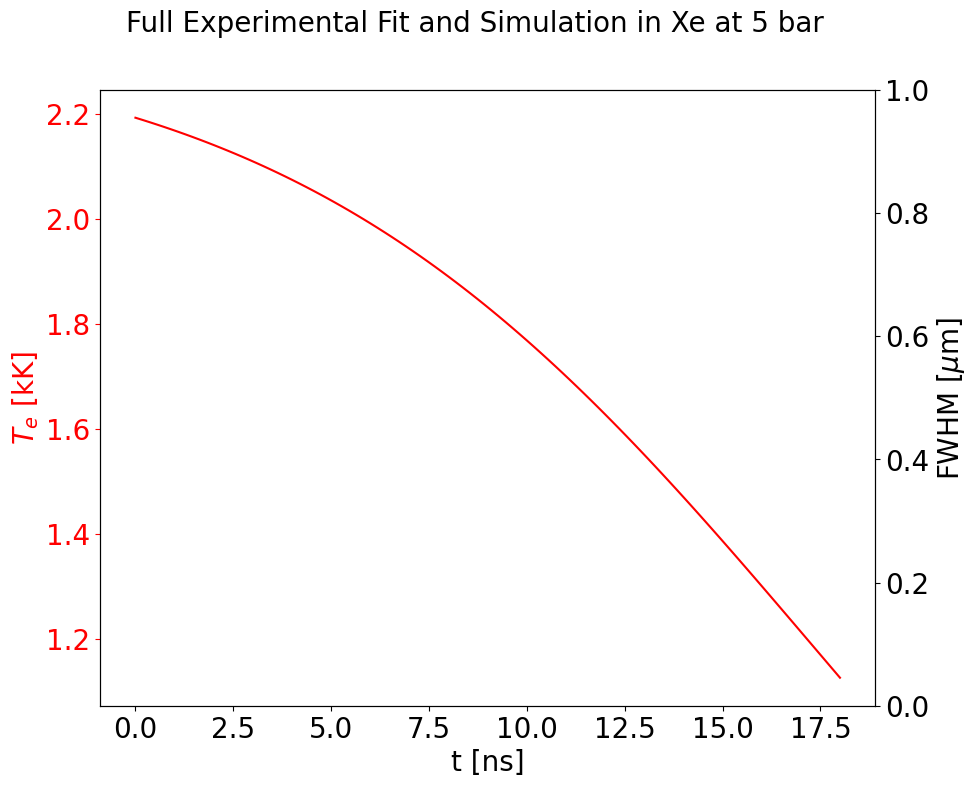

In [171]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

dense_t_list = np.linspace(0,18,num=100)
# def T_fit_form(t, T0, a, b, c, d, e, t0):
#     return 0*T0 + 0*a*np.exp(-2*t/b) + (1/(1+np.exp( c*(t-t0))))#* (d*t+ e)

def T_fit_form(t, T0, ΔT, τei, τ_switch, t01,dTdt):
    return 0*T0 + 0*ΔT*np.exp(-2*t/τei) + (1-1/(1+np.exp( (t-t01)/τ_switch )))* dTdt

# def FWHM_fit_form(t, FWHM_0, vf, a, b, c, d, t0):
#     return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c) + d

# ax.plot(Xe_data['t[ns]'], T_fit_form(Xe_data['t[ns]'],*Te_vals), 'r--', label='Experiment Data')
# ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'rx', label='Experiment Data')
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'r.')
ax.plot(dense_t_list, T_fit_form(dense_t_list,*Te_sim_vals),'r-')
# ax.plot(np.array(FWHM_t_list)*1e9, T_fit_form(np.array(FWHM_t_list)*1e9,*Te_sim_vals),'r-')
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'.', color='r', )


ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
# ax2.plot(Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'], 'kx', label='Experiment Data')
# ax2.plot(Xe_FWHM_data['t[ns]'], FWHM_fit_form(Xe_FWHM_data['t[ns]'],*FWHM_vals),'k--')
# ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'.k')
# ax2.plot(dense_t_list, FWHM_fit_form(dense_t_list,*FWHM_sim_vals),'k-')



ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)
# ax.set_xscale('log')
# ax2.set_yscale('log')
# ax.set_xlim(0,3)

In [159]:
def plot_bulk_temperature(ttm,ax, plot_times = None, title=''):
    bulk_Tes = np.array(Te_fit_list)

    ti_1, ti_2 = -40, -39

    dT_dt  = (bulk_Tes[ti_2] - bulk_Tes[ti_1])/(FWHM_t_list[ti_2] - FWHM_t_list[ti_1])

#     T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_fit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_DIHfit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 1470 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -120 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, 30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
    ax.set_ylim(10,17)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)


ValueError: x and y must have same first dimension, but have shapes (1799,) and (40,)

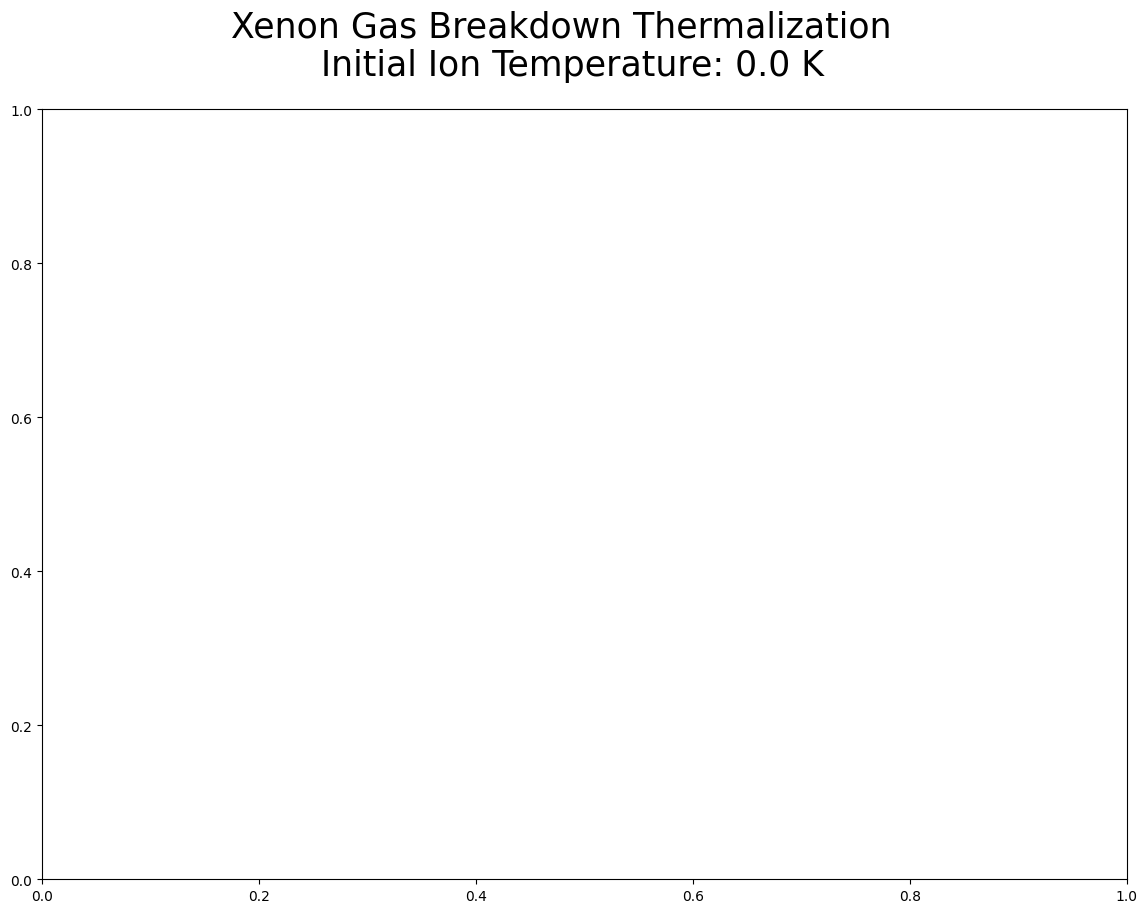

In [160]:
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
fig.suptitle('Xenon Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm, ax[0], title='JT GMS')
fig.tight_layout()